<a href="https://colab.research.google.com/github/annie-lyu/word-embedding/blob/master/doc2vec_(with_pretrained_word_embeddings)_reddit_rm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import glob
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import gensim.models as g
import logging
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedLineDocument, TaggedDocument

In [4]:
##optimal hyperparameter setting found by Lau and Baldwin (2016) and confirmed by 
vector_size = 300
window_size = 15
min_count = 1
sampling_threshold = 1e-5
negative_size = 5
train_epoch = 100
dm = 0
worker_count = 1 

In [5]:
pretrained_emb = "/content/drive/My Drive/test/glove.6B.100d.txt"
saved_path = "/content/drive/My Drive/test/model_6k_rm.bin"
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [6]:
import re
def removePunctuation(text):
    punctuation = '\\\\!,;:?"\'.-=^/|+-'
    text = re.sub(r'[{}]+'.format(punctuation),'',text)
    text = text.replace("\n", "")
    return text

In [7]:
import nltk
with open("/content/drive/My Drive/test/reddit_6k.txt",encoding='latin-1') as f:
    data = f.read().lower().replace('"', "")
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = list(set(stopwords.words('english')))

text = data.split("\n")
removed = []
for corpus in text:
  words = corpus.split(" ")
  word = [word for word in words if word not in stop_words]
  removed += [word]

new_corpus = [" ".join(words) for words in removed]
new_data = "\n".join(new_corpus)


with open('/content/drive/My Drive/test/reddit_6k_utf8_rmstop.txt','w',encoding='utf8') as f:
    f.write(new_data)

docs = g.doc2vec.TaggedLineDocument('/content/drive/My Drive/test/reddit_6k_utf8_rmstop.txt')




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:

model_6k_rm = g.Doc2Vec(docs, size=vector_size, window=window_size, min_count=min_count, sample=sampling_threshold, workers=worker_count, hs=0, dm=dm, negative=negative_size, dbow_words=1, dm_concat=1, pretrained_emb=pretrained_emb, iter=train_epoch)

#save model
model_6k_rm.save(saved_path)


/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:566: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
2020-08-20 07:12:32,562 : INFO : collecting all words and their counts
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-08-20 07:12:32,571 : I

In [14]:
    outp1 = "reddit_6k_wv"
    outp2 = "reddit_6k_pv"
    outp3 = "reddit_6k_output"
    model_6k_rm.wv.save_word2vec_format(outp3) 

2020-08-20 03:18:05,985 : INFO : storing 10773x300 projection weights into reddit_6k_output
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
#model = g.doc2vec.Doc2Vec.load("/content/drive/My Drive/test/model.bin")

In [9]:
#normalise vectors
import numpy as np
sum_of_rows = model_6k_rm.wv.syn0.sum(axis=1)
normalized = model_6k_rm.wv.syn0 / sum_of_rows[:, np.newaxis]
#normalized = np.delete(normalized,[829, 10172], 0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  after removing the cwd from sys.path.


In [25]:
##clustering with pyclustering
!pip3 install pyclustering
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.samples.definitions import FCPS_SAMPLES
from pyclustering.utils import read_sample
from pyclustering.utils.metric import distance_metric, type_metric


# Prepare initial centers using K-Means++ method.
initial_centers = kmeans_plusplus_initializer(normalized, 4).initialize()
 
# Create instance of K-Means algorithm with prepared centers.
kmeans_instance = kmeans(normalized, initial_centers)

# Run cluster analysis and obtain results.
kmeans_instance.process()
clusters = kmeans_instance.get_clusters()
final_centers = kmeans_instance.get_centers()

# Visualize obtained results
#cluster_visualizer.show_clusters(model.wv.syn0, clusters, final_centers)
[len(i) for i in clusters]

[10770, 1, 1, 1]

In [27]:
print(clusters[1])
print(clusters[2])
print(clusters[3])

[10328]
[9859]
[6272]


In [23]:
clusters[2]

[6272]

In [37]:
[model_6k_rm.wv.index2word[i] for i in clusters[1]]

['two',
 'idiot',
 'site',
 'ignorant',
 'excellent',
 'topic',
 'titanic',
 'ports',
 'coupled',
 'patched',
 'reclamation',
 'eazy',
 'jason',
 'flaccos']

In [26]:

model_6k_rm.wv.index2word[829]
model_6k_rm.wv.index2word[10172]

'foraging'

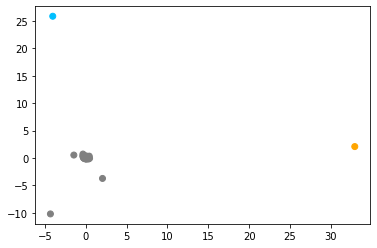

In [38]:
import numpy
import numpy as np
import gensim
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import Doc2Vec


pca = PCA(n_components=2).fit(normalized)
datapoint = pca.transform(normalized)
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure
label1 = ["gray", "orange", "deepskyblue", "crimson", "cornflowerblue", 
          "mediumseagreen", "gold"]

col = [0]* len(normalized)
for i in range(1,len(clusters)-1):
  cl = clusters[i][0]
  col[cl] = i

color = [label1[i] for i in col]

plt.scatter(datapoint[:, 0], datapoint[:, 1],  c=color)
centroids = final_centers
centroidpoint = pca.transform(centroids)
#plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker="^", s=150, c="#000000")
plt.show()


In [36]:
clusters[1]

[10328]

For n_clusters = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 5, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0

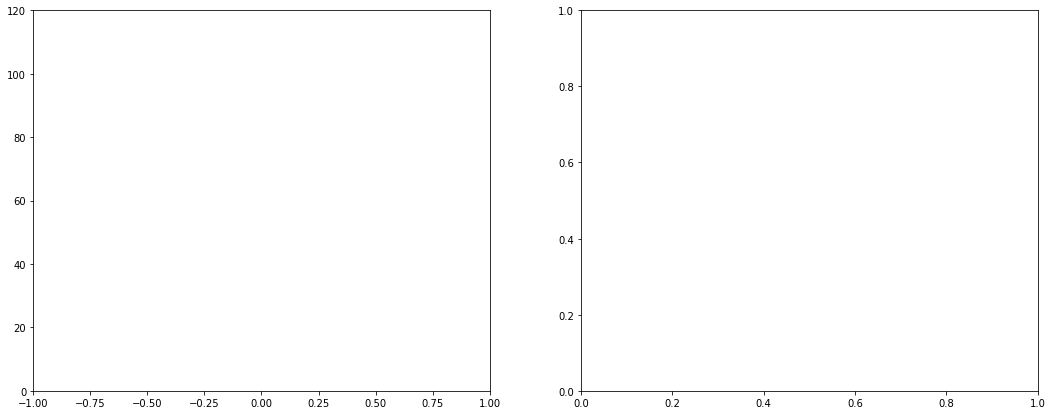

In [44]:
#evaluation with silhouette
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
ax1.set_xlim([-1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(clusters) + (10 + 1) * 10])

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(normalized, metric = "euclidean", labels = col)
print("For n_clusters =", col,
          "The average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(normalized, metric = "euclidean", labels =col)


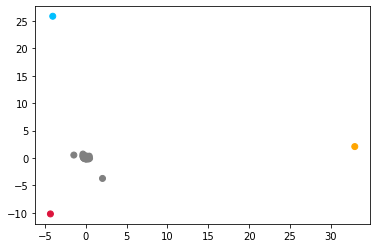

In [24]:
##clustering with sklearn package
import numpy
import numpy as np
import gensim
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import Doc2Vec

kmeans_model = KMeans(n_clusters=4, init='k-means++', max_iter=100) 
X = kmeans_model.fit(normalized)
labels=kmeans_model.labels_.tolist()
l = kmeans_model.fit_predict(normalized)
pca = PCA(n_components=2).fit(normalized)
datapoint = pca.transform(normalized)
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure
label1 = ["gray", "orange", "deepskyblue", "crimson", "cornflowerblue", 
          "mediumseagreen", "gold", "salmon", "palegreen", "mediumslateblue"]
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
#plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker="^", s=150, c="#000000")
plt.show()

In [26]:
##clustering with ntkl packages
[i for i in range(len(labels)-1) if labels[i] != 0]

[9859, 10328, 10703]

In [39]:
print(model_6k_rm.wv.index2word[10328])
print(model_6k_rm.wv.index2word[9859])
print(model_6k_rm.wv.index2word[10703])
print(model_6k_rm.wv.index2word[6272])

420bakeit
huehuehue
woooooooooooooooooooooooooo
stroke
